<a href="https://colab.research.google.com/github/elizaveta-alx/admanced_ml/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 48 kB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 488 kB 57.4 MB/s 
     |████████████████████████████████| 3.1 MB 45.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220929150707
    Uninstalling tensorflow-2.8.2+zzzcolab20220929150707:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220929150707
ERROR: pip's dependency resolver does not currently ta

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [84]:
fashion_mnist = input_data.read_data_sets('./fashionmnist')

input_size = 28 * 28
num_clothes = 10

Extracting ./fashionmnist/train-images-idx3-ubyte.gz
Extracting ./fashionmnist/train-labels-idx1-ubyte.gz
Extracting ./fashionmnist/t10k-images-idx3-ubyte.gz
Extracting ./fashionmnist/t10k-labels-idx1-ubyte.gz


In [85]:
params = {
    'encoder_layers': [128, 64, 32],                
    'decoder_layers': [32, 64, 128],                
    'clothes_classification_layers': [128, 64, 32],   # for conditions
    'activation': tf.nn.sigmoid,            
    'decoder_std': 0.5,                     # std for P(x|z) 
    'z_dim': 10,                            # latent space dimension
    'digit_classification_weight': 10.0,    # for conditions
    'epochs': 50,
    'batch_size': 100,
    'learning_rate': 0.001
}

In [86]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    logits = tf.layers.dense(x, num_clothes)
    return logits

In [87]:
images = tf.placeholder(tf.float32, [None, input_size])
clothes = tf.placeholder(tf.int32, [None])

# sample the vector from latent space, using
# reparametrization
eps = tf.random_normal(shape=[tf.shape(images)[0],
                              params['z_dim']],
                       mean=0.0,
                       stddev=1.0)

# classify the digit
digit_logits = digit_classifier(images,
                                params['clothes_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)



In [88]:
# encode the image into latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])

z = encoder_mu + tf.sqrt(encoder_var) * eps

# decode latent vector using digit classification condition into the image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
                         params['decoder_layers'])

In [89]:
# loss for reconstructed image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# loss for the current hidden space distribution parameters
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

# autoencoder loss
loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# loss for digit_classification
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=clothes,
                                                   logits=digit_logits),
    axis=0
)

# final loss
loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [90]:
# Training
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        print("Epoch # - ",epoch)
        for _ in range(fashion_mnist.train.num_examples // params['batch_size']):
            batch_images, batch_clothes = fashion_mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, clothes: batch_clothes})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: fashion_mnist.train.images, clothes: fashion_mnist.train.labels})
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        print("Loss: ",train_loss_auto_encode + train_loss_digit_classifier)

        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_clothes, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_clothes)})
        samples.append(gen_samples)

print("\nTraining completed!")


Epoch # -  0
Loss:  287.55005
Epoch # -  1
Loss:  261.63162
Epoch # -  2
Loss:  247.52344
Epoch # -  3
Loss:  242.60385
Epoch # -  4
Loss:  238.12271
Epoch # -  5
Loss:  235.01837
Epoch # -  6
Loss:  232.20145
Epoch # -  7
Loss:  230.2121
Epoch # -  8
Loss:  228.7093
Epoch # -  9
Loss:  227.37723
Epoch # -  10
Loss:  226.1802
Epoch # -  11
Loss:  225.35185
Epoch # -  12
Loss:  224.51183
Epoch # -  13
Loss:  223.87843
Epoch # -  14
Loss:  223.39008
Epoch # -  15
Loss:  222.64815
Epoch # -  16
Loss:  222.27032
Epoch # -  17
Loss:  221.67383
Epoch # -  18
Loss:  221.6261
Epoch # -  19
Loss:  221.04474
Epoch # -  20
Loss:  220.71129
Epoch # -  21
Loss:  220.328
Epoch # -  22
Loss:  220.034
Epoch # -  23
Loss:  219.83249
Epoch # -  24
Loss:  219.58896
Epoch # -  25
Loss:  219.31886
Epoch # -  26
Loss:  219.1296
Epoch # -  27
Loss:  218.86574
Epoch # -  28
Loss:  218.70393
Epoch # -  29
Loss:  218.43141
Epoch # -  30
Loss:  218.18488
Epoch # -  31
Loss:  218.07727
Epoch # -  32
Loss:  217.84

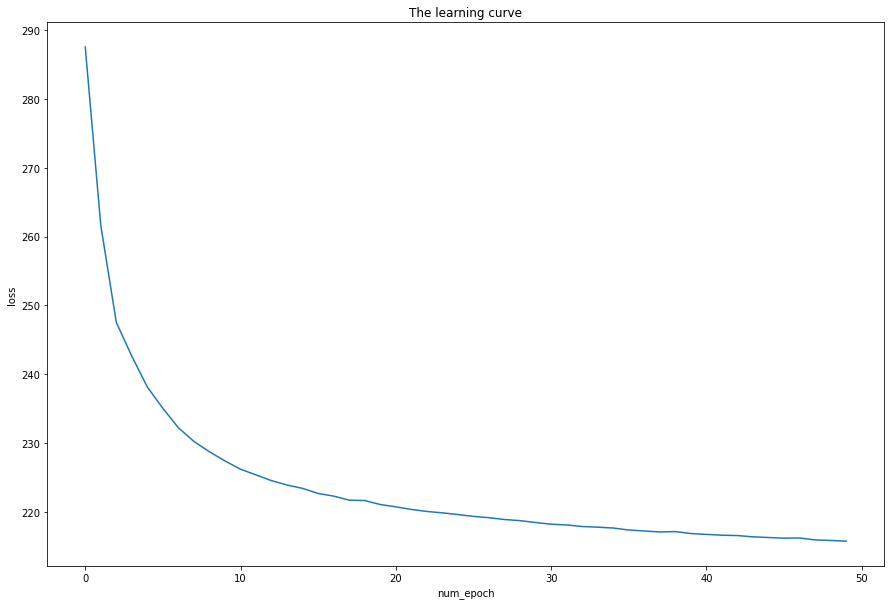

In [92]:
plt.figure(figsize=[15,10])
plt.plot(np.array(losses_auto_encode)+np.array(losses_digit_classifier))
plt.title('The learning curve')
plt.ylabel('loss')
plt.xlabel('num_epoch')
plt.show()

In [108]:
def plot_samples(samples):
    IMAGE_WIDTH = 1.2
    plt.figure(figsize=(IMAGE_WIDTH * num_clothes,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for clothes, image in enumerate(images):
            plt.subplot(len(samples),
                        num_clothes,
                        epoch * num_clothes + clothes + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if clothes == 0:
                plt.gca().yaxis.set_ticks([])
                
            else:
                plt.gca().yaxis.set_visible(False)


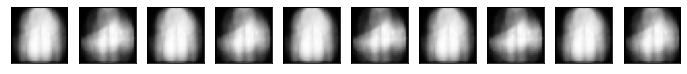

In [109]:
plot_samples([samples[0]])

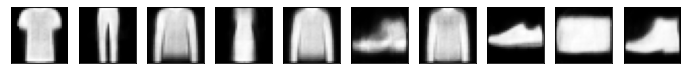

In [110]:
plot_samples([samples[10]])

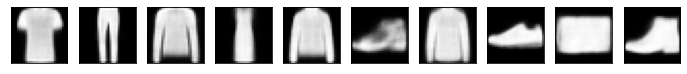

In [111]:
plot_samples([samples[20]])

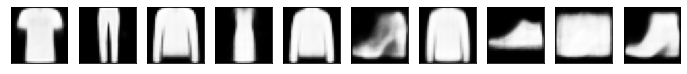

In [112]:
plot_samples([samples[30]])

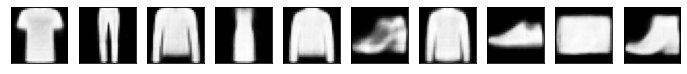

In [113]:
plot_samples([samples[40]])

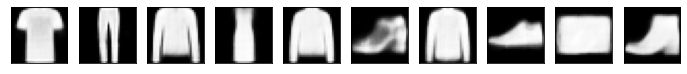

In [114]:
plot_samples([samples[49]])